<a href="https://colab.research.google.com/github/KMR-86/ml-test-processing-basic/blob/master/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/google_colab_datasets
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/google_colab_datasets
amazon-fine-food-reviews/


In [0]:

import sqlite3
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [45]:
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite')
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000", con) 
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape
filtered_data.head(1)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [46]:
def preprocessing(df):
  df=df[df["HelpfulnessNumerator"]<=df["HelpfulnessDenominator"]]
  print(df.shape)
  df=df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
  print(df.shape)
  return df




print(filtered_data.shape)
df=preprocessing(filtered_data)
print("data left : ", df.shape[0]/filtered_data.shape[0])



(5000, 10)
(5000, 10)
(4986, 10)
data left :  0.9972


In [0]:
preprocessed_reviews=df["Text"]

list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)


In [48]:

for element in w2v_model.wv.most_similar('tasty'):
  print(element)


('tasty.', 0.9937354922294617)
('tasty,', 0.9865029454231262)
('flavorful.', 0.9846007823944092)
('delicious.', 0.9838851690292358)
('light', 0.9825781583786011)
('delicious,', 0.979085385799408)
('delicious', 0.9789922833442688)
('very,', 0.9786690473556519)
('crunchy', 0.9784476161003113)
('weak', 0.978162944316864)


In [49]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in list(w2v_model.wv.vocab):
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████| 4986/4986 [00:47<00:00, 104.85it/s]

4986
50


In [50]:
from sklearn.manifold import TSNE
x = TSNE(n_components=2).fit_transform(sent_vectors)
print(x.shape)
print(x[0])



(4986, 2)
[-17.292286  39.24818 ]


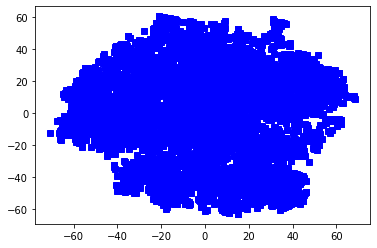

In [51]:
import matplotlib.pyplot as plt
plt.plot(x.T[0],x.T[1],"bs")
plt.show()